In [1]:
# Make imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import datetime 

from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_curve, auc

In [2]:
# Read the data
users = pd.read_csv('relax_challenge/takehome_users.csv',  encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
engagement = pd.read_csv('/Users/danielvalle/Documents/Coding/Springboard/relax_challenge/takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

In [6]:
len(engagement['user_id'].unique())

8823

## Data wrangling

In [7]:
# Reset index to time_stamp
engagement['time_stamp'] = engagement['time_stamp'].apply(pd.to_datetime) 
engagement.set_index(engagement['time_stamp'], inplace=True)

# Group users by their weekly sign ups
engagement2 = engagement.groupby(by=['user_id', pd.Grouper(freq='7D')]).sum()
engagement2.head(15)

visited
user_id time_stamp                  
1       2014-04-17 08:20:06        1
2       2013-11-14 08:20:06        1
        2013-11-28 08:20:06        1
        2013-12-05 08:20:06        1
        2013-12-19 08:20:06        1
        2013-12-26 08:20:06        1
        2014-01-02 08:20:06        1
        2014-01-30 08:20:06        1
        2014-02-06 08:20:06        3
        2014-02-13 08:20:06        1
        2014-03-06 08:20:06        2
        2014-03-27 08:20:06        1
3       2013-03-14 08:20:06        1
4       2013-05-16 08:20:06        1
5       2013-01-17 08:20:06        1

In [8]:
# Create a new column for 'adopted_user'
engagement3 = engagement2.groupby(level=0).visited.max().reset_index(name='maxvisitsxweek')
engagement3.set_index('user_id', inplace=True)
engagement3['adopted_user'] = [1 if x >= 3 else 0 for x in engagement3['maxvisitsxweek']]
engagement3.head(10)

,maxvisitsxweek,adopted_user
user_id,,
1,1,0
2,3,1
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
10,7,1
11,1,0


In [9]:
engagement3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 2 columns):
maxvisitsxweek    8823 non-null int64
adopted_user      8823 non-null int64
dtypes: int64(2)
memory usage: 206.8 KB


In [10]:
# Merge dataframes
users.set_index('object_id', inplace=True)   # Set index of users dataframe to 'object_id'

df = pd.merge(users, engagement3, how='left', left_index=True, right_index=True)
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,maxvisitsxweek,adopted_user
object_id,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,3.0,1.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0,0.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,0.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,0.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
maxvisitsxweek                8823 non-null float64
adopted_user                  8823 non-null float64
dtypes: float64(4), int64(3), object(4)
memory usage: 1.4+ MB


Text(0.5,0,'')

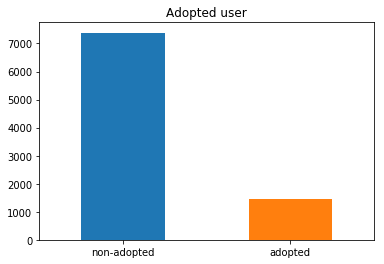

In [12]:
# Visualize proportion of adopted vs non-adopted users
labels=['non-adopted', 'adopted']

df.groupby('adopted_user').size().plot.bar()
plt.title('Adopted user')
plt.xticks(range(2), labels, rotation='horizontal')
plt.xlabel('')

In [13]:
df.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            11991, 11992, 11993, 11994, 11995, 11996, 11997, 11998, 11999,
            12000],
           dtype='int64', name='object_id', length=12000)

In [14]:
# Drop rows that do not have info about user adoption; fill na value for other columns
df = df.dropna(subset=['adopted_user'])
df.fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 11 columns):
creation_time                 8823 non-null object
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            8823 non-null float64
maxvisitsxweek                8823 non-null float64
adopted_user                  8823 non-null float64
dtypes: float64(4), int64(3), object(4)
memory usage: 827.2+ KB


## Data cleaning

In [15]:
# Creation time
df['day'] = pd.to_datetime(df["creation_time"]).dt.weekday_name
df['month'] = pd.to_datetime(df["creation_time"]).dt.month
df['hour'] = pd.to_datetime(df["creation_time"]).dt.hour

# Email
df['email'] = df['email'].apply(lambda x: x.split('@')[1].split('.')[0])
print(df['email'].value_counts()[:10])
common_emails = ['gmail', 'yahoo', 'jourrapide', 'gustr', 'cuvox', 'hotmail']
df['email'] = ['uncommon' if x not in common_emails else x for x in df['email']]
print(df['email'].value_counts())

# Last session
df['creation_time'] = pd.to_datetime(df['creation_time'])

# Convert unix to datetime
df['last_session_creation_time'] = df['last_session_creation_time'].apply(lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S'))
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time']) # convert to int
df['last_session_creation_time'] = df['last_session_creation_time'] - df['creation_time'] # difference between creation and last login (days)
df['last_session'] = (df['last_session_creation_time'] / np.timedelta64(1, 'D')).astype(int) # convert to int type

gmail         2930
yahoo         1726
jourrapide     883
gustr          842
cuvox          828
hotmail        803
luque            2
mumdc            2
xvnbr            2
xybhi            2
Name: email, dtype: int64
gmail         2930
yahoo         1726
jourrapide     883
gustr          842
cuvox          828
uncommon       811
hotmail        803
Name: email, dtype: int64


In [16]:
# Create dummy variables for categorical data
data = pd.get_dummies(df, columns=['email', 'creation_source', 'day'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 31 columns):
creation_time                         8823 non-null datetime64[ns]
name                                  8823 non-null object
last_session_creation_time            8823 non-null timedelta64[ns]
opted_in_to_mailing_list              8823 non-null int64
enabled_for_marketing_drip            8823 non-null int64
org_id                                8823 non-null int64
invited_by_user_id                    8823 non-null float64
maxvisitsxweek                        8823 non-null float64
adopted_user                          8823 non-null float64
month                                 8823 non-null int64
hour                                  8823 non-null int64
last_session                          8823 non-null int64
email_cuvox                           8823 non-null uint8
email_gmail                           8823 non-null uint8
email_gustr                           8823 non-null ui

## Model the data

In [17]:
# Separate variables into train and test
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.
                                            difference(['creation_time', 'name', 'maxvisitsxweek', 'last_session_creation_time', 'adopted_user'])], 
                                            data['adopted_user'], test_size=0.25, random_state=123)

In [18]:
# Instantiate classifiers
classifiers = [linear_model.LogisticRegression(solver='lbfgs' , C=10000), 
              MultinomialNB(), 
              BernoulliNB(), 
              RandomForestClassifier(n_estimators=20, max_depth=30, random_state=30), 
              KNeighborsClassifier(), 
              SVC()]

In [19]:
# Define a function to run the classifiers
def run_classifiers(X_train, X_test, y_train, y_test, classifiers):
    # Create a dataframe with results
    results_cols = ['Classifier', 'Train score', 'Test score', 'Accuracy', 'Log Loss']
    results = pd.DataFrame(columns = results_cols)

    predictions_cols = ['Logistic_regression', 'MultinomialNB', 'BernoulliNB', 'RandomForest', 'KNeighbors', 'SVC']
    global predictions
    predictions = pd.DataFrame()

    for clf in classifiers:
        clf.fit(X_train, y_train)
    
        name = clf.__class__.__name__
    
        print('='*30)
        print(name)
    
        print('**** Results ****')
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        print('Train score: {:.4%}'.format(train_score))
        print('Test score: {:.4%}'.format(test_score))
    
        prediction = clf.predict(X_test)
        acc = accuracy_score(y_test, prediction)
        print("Accuracy: {:.4%}".format(acc))
        log_predictions = pd.DataFrame(prediction.tolist())
        predictions = pd.concat([predictions, log_predictions], axis = 1)
    
    
        try:
            train_predictions = clf.predict_proba(X_test)
            ll = log_loss(y_test, train_predictions)
            print("Log Loss: {}".format(ll))
        except:
            ll = 'Not applicable'
    
        #acc and ll have been removed
        log_entry = pd.DataFrame([[name, train_score, test_score, acc, ll]], columns = results_cols)
        results = results.append(log_entry)
        
    # Get results in one view
    print(results.head())
    predictions.columns = predictions_cols
    print('*' * 40)
    print(predictions.head())

In [20]:
run_classifiers(X_train, X_test, y_train, y_test, classifiers)

LogisticRegression
**** Results ****
Train score: 97.1588%
Test score: 96.3282%
Accuracy: 96.3282%
Log Loss: 0.09991106482085724
MultinomialNB
**** Results ****
Train score: 86.6556%
Test score: 85.9021%
Accuracy: 85.9021%
Log Loss: 3.176767603926308
BernoulliNB
**** Results ****
Train score: 83.3157%
Test score: 82.6383%
Accuracy: 82.6383%
Log Loss: 0.31158098763668307
RandomForestClassifier
**** Results ****
Train score: 99.9698%
Test score: 96.3282%
Accuracy: 96.3282%
Log Loss: 0.22079693470449452
KNeighborsClassifier
**** Results ****
Train score: 96.9624%
Test score: 95.8749%
Accuracy: 95.8749%
Log Loss: 0.720939815713912
SVC
**** Results ****
Train score: 99.9395%
Test score: 83.8622%
Accuracy: 83.8622%
               Classifier  Train score  Test score  Accuracy   Log Loss
0      LogisticRegression     0.971588    0.963282  0.963282  0.0999111
0           MultinomialNB     0.866556    0.859021  0.859021    3.17677
0             BernoulliNB     0.833157    0.826383  0.826383   0.

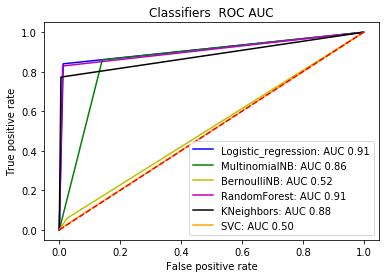

In [21]:
# ROC curve
cmp = 0
colors = ['b', 'g', 'y', 'm', 'k', 'orange']
for model, predict in predictions.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers  ROC AUC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.show()

In [22]:
# Tune hyper-parameters for the best classifier and cross-validate: RandomForestClassifier
params_grid = {'n_estimators': [30, 60, 100], 'max_depth': [35, 40, 50]}

grid = GridSearchCV(RandomForestClassifier( random_state=30), params_grid, cv=10)
grid.fit(X_train, y_train)

best_forest_grid = grid.best_estimator_

# Review scores
print('train data score:', best_forest_grid.score(X_train, y_train))
print('test data score:', best_forest_grid.score(X_test, y_test))

train data score: 1.0
test data score: 0.9632819582955575


In [23]:
best_forest_grid

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=30, verbose=0, warm_start=False)

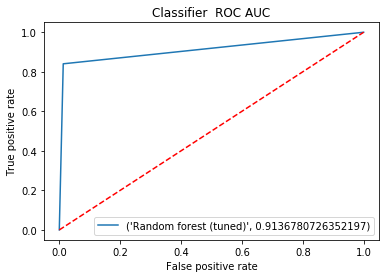

In [24]:
# ROC curve for tuned randomforest classifier
rf_cv_prediction = best_forest_grid.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf_cv_prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, label=('Random forest (tuned)', roc_auc))


plt.title('Classifier  ROC AUC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.show()

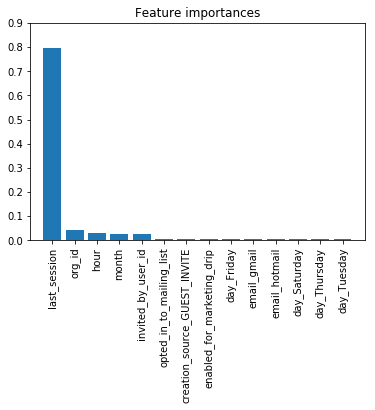

In [25]:
# Identify the most import features
importances = np.asarray(sorted(best_forest_grid.feature_importances_, reverse=True)[:14])
indices = np.argsort(importances)[::-1]

# Create labels
X_train = [str(i) for i in X_train]
feature_importance_values = list(zip(best_forest_grid.feature_importances_, X_train))
features = sorted(feature_importance_values, key = lambda x: x[0], reverse=True)[:14]
labels = [x[1] for x in features]

# Plot 30 most important features
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), labels, rotation=90)
plt.xlim([-1, 14])
plt.ylim([0, 0.90])
plt.show()

In [26]:
data['last_session'].value_counts()[:10]

0     4644
1      822
2      405
3      195
4      120
5       74
24      47
26      46
7       40
19      40
Name: last_session, dtype: int64

In [27]:
data.corr()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,maxvisitsxweek,adopted_user,month,hour,last_session,email_cuvox,...,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
opted_in_to_mailing_list,1.000000,0.488219,-0.002421,0.010839,0.011956,0.004201,-0.009109,0.007390,0.005562,-0.017808,...,-0.005339,0.002632,-0.008198,-0.004048,0.000457,-0.006466,-0.006274,0.010973,-0.008905,0.013917
enabled_for_marketing_drip,0.488219,1.000000,0.000538,-0.000173,-0.000201,0.000246,-0.005481,0.013430,0.007389,-0.000917,...,-0.018095,0.011159,-0.003042,-0.003125,-0.006503,-0.015269,0.001160,0.018595,0.000683,0.003983
org_id,-0.002421,0.000538,1.000000,-0.042723,0.069782,0.072860,-0.004828,-0.011305,0.064458,0.000238,...,0.010924,0.015432,-0.003645,-0.004495,0.010051,-0.005807,-0.016281,0.005962,0.011263,-0.000890
invited_by_user_id,0.010839,-0.000173,-0.042723,1.000000,0.023047,0.022959,-0.014805,0.010879,0.014147,0.060431,...,-0.256377,-0.435925,-0.359311,0.004506,-0.000334,-0.009075,-0.011464,0.000875,0.011508,0.003702
maxvisitsxweek,0.011956,-0.000201,0.069782,0.023047,1.000000,0.919908,0.066188,0.006742,0.914992,-0.012722,...,0.019572,-0.031738,-0.015375,-0.010578,-0.007558,0.022934,-0.008318,0.005634,-0.005525,0.003728
adopted_user,0.004201,0.000246,0.072860,0.022959,0.919908,1.000000,0.059852,0.001558,0.816093,-0.010566,...,0.014611,-0.029533,-0.019302,-0.005379,-0.006296,0.017661,-0.007375,-0.001408,0.000058,0.003055
month,-0.009109,-0.005481,-0.004828,-0.014805,0.066188,0.059852,1.000000,-0.000391,0.074411,0.016122,...,0.012297,0.014685,-0.006094,0.005356,-0.000255,0.015672,0.013467,-0.000520,-0.010997,-0.022569
hour,0.007390,0.013430,-0.011305,0.010879,0.006742,0.001558,-0.000391,1.000000,0.008780,0.011124,...,-0.019165,0.003736,-0.010949,-0.006519,-0.001879,-0.003384,0.003013,0.015758,-0.002177,-0.005004
last_session,0.005562,0.007389,0.064458,0.014147,0.914992,0.816093,0.074411,0.008780,1.000000,-0.016764,...,0.017805,-0.032368,-0.003193,-0.014113,-0.002134,0.017818,-0.010607,0.009976,-0.004533,0.003809
email_cuvox,-0.017808,-0.000917,0.000238,0.060431,-0.012722,-0.010566,0.016122,0.011124,-0.016764,1.000000,...,0.018383,0.026372,-0.138868,-0.017880,0.023279,0.010126,-0.026643,0.014728,0.001550,-0.005212


## Future user adoption

An 'adopted' user is considered as a user who has signed at least three times in a seven day period. One factor that predicts future user adoption is the time in between sign up for the product and last login. Thus, the company may want to give spreadout promotions in order to motivate users to use the service weeks or months after they have signed up. However, this predicting factor may work differently for users who are already adopted in contrast to those who still are not because it is expected that adopted users use the service more frequently. 

A second important predicting factor is the organization that the user belongs to. This factor does not show the same caveat as the last login factor. Thus, the company may focus an advertisement campaing to the organizations with the most 'adopted' users. 

A third major predicting factor is the user who promoted the service to a third party. Thus, a more personalized approach to increase user adoption is to incentivize current users to reffer the service to acquaintances. 